In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, GRU,LSTM, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import math

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

np.random.seed(123)
tf.random.set_seed(123)

In [169]:
df=pd.read_csv('./INFY.csv',index_col='Date',parse_dates=True)

In [170]:
df

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,INFOSYSTCH,EQ,14467.75,15625.00,15625.20,15625.00,15625.20,15625.20,15625.18,5137,8.026657e+12,NaN,NaN,NaN
2000-01-04,INFOSYSTCH,EQ,15625.20,16800.00,16875.25,16253.00,16875.25,16855.90,16646.38,56186,9.352937e+13,NaN,NaN,NaN
2000-01-05,INFOSYSTCH,EQ,16855.90,15701.00,16250.00,15507.45,15507.45,15507.45,15786.38,164605,2.598516e+14,NaN,NaN,NaN
2000-01-06,INFOSYSTCH,EQ,15507.45,15256.65,15300.00,14266.85,14266.85,14266.85,14462.82,81997,1.185908e+14,NaN,NaN,NaN
2000-01-07,INFOSYSTCH,EQ,14266.85,13125.50,13125.50,13125.50,13125.50,13125.50,13125.50,7589,9.960942e+12,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,INFY,EQ,1333.80,1332.25,1351.30,1321.00,1345.00,1343.55,1343.19,7088606,9.521361e+14,130375.0,4218129.0,0.5951
2021-04-27,INFY,EQ,1343.55,1346.00,1353.00,1340.15,1347.50,1348.50,1346.89,3636115,4.897445e+14,145974.0,1871084.0,0.5146
2021-04-28,INFY,EQ,1348.50,1358.00,1359.50,1344.60,1355.80,1356.00,1353.45,4879234,6.603778e+14,137376.0,2857134.0,0.5856


In [171]:
df['Date']=df.index

In [172]:
start_date='2016-01-01'
end_date='2020-12-31'
mask=(df['Date']>=start_date)&(df['Date']<=end_date)

In [173]:
df=df.loc[mask]

In [174]:
df=df.loc[mask]

In [175]:
df=df.drop(columns=['Series','Symbol','Open','High','Low','Last','Close','VWAP','Volume','Turnover','Trades','Deliverable Volume','%Deliverble','Date'])

In [176]:
Ntest=math.trunc(0.3*len(df))
train=df.iloc[:-Ntest]
test=df.iloc[-Ntest:]

In [177]:
train_idx=df.index<=train.index[-1]
test_idx=df.index>train.index[-1]

In [178]:
df['Diff Prev Close']=df['Prev Close'].diff()

In [179]:
series=df['Diff Prev Close'].dropna().to_numpy()

T=50
X=[]
Y=[]
for t in range(len(series)-T):
  x=series[t:t+T]
  X.append(x)
  y=series[t+T]
  Y.append(y)

X=np.array(X).reshape(-1,T)
Y=np.array(Y)
N=len(X)
print("X.shape",X.shape,"Y.shape",Y.shape)

X.shape (1187, 50) Y.shape (1187,)


In [180]:
Xtrain,Ytrain=X[:-Ntest],Y[:-Ntest]
Xtest,Ytest=X[-Ntest:],Y[-Ntest:]

Bi-LSTM

In [181]:
i=Input(shape=(T,1))
x=Bidirectional(LSTM(200,return_sequences=True))(i)
x=Bidirectional(LSTM(200,return_sequences=True))(x)
x=GlobalMaxPool1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_bi_lstm=Model(i,x)
model_bi_lstm.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 50, 1)]           0         
                                                                 
 bidirectional_20 (Bidirecti  (None, 50, 400)          323200    
 onal)                                                           
                                                                 
 bidirectional_21 (Bidirecti  (None, 50, 400)          961600    
 onal)                                                           
                                                                 
 global_max_pooling1d_10 (Gl  (None, 400)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_30 (Dense)            (None, 100)               40100     
                                                          

In [182]:
check_point_bi_lstm=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [183]:
model_bi_lstm.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [184]:
r=model_bi_lstm.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_bi_lstm]
)

Epoch 1/100
26/26 [==============================] - 27s 759ms/step - loss: 801.5783 - mae: 11.2233 - mse: 801.5783 - val_loss: 331.8176 - val_mae: 12.2423 - val_mse: 331.8176
Epoch 2/100
26/26 [==============================] - 18s 677ms/step - loss: 798.9897 - mae: 11.1725 - mse: 798.9897 - val_loss: 333.0276 - val_mae: 12.2623 - val_mse: 333.0276
Epoch 3/100
26/26 [==============================] - 18s 694ms/step - loss: 796.9224 - mae: 11.1543 - mse: 796.9224 - val_loss: 333.9950 - val_mae: 12.2700 - val_mse: 333.9950
Epoch 4/100
26/26 [==============================] - 18s 698ms/step - loss: 796.2259 - mae: 11.1380 - mse: 796.2259 - val_loss: 335.4282 - val_mae: 12.3085 - val_mse: 335.4282
Epoch 5/100
26/26 [==============================] - 18s 684ms/step - loss: 795.3876 - mae: 11.1286 - mse: 795.3876 - val_loss: 334.8273 - val_mae: 12.2809 - val_mse: 334.8273
Epoch 6/100
26/26 [==============================] - 18s 677ms/step - loss: 795.0463 - mae: 11.1783 - mse: 795.0463 - va

Bi-directional GRU

In [185]:
i=Input(shape=(T,1))
x=Bidirectional(GRU(200,return_sequences=True))(i)
x=Bidirectional(GRU(200,return_sequences=True))(x)
x=GlobalMaxPool1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_bi_gru=Model(i,x)
model_bi_gru.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 50, 1)]           0         
                                                                 
 bidirectional_22 (Bidirecti  (None, 50, 400)          243600    
 onal)                                                           
                                                                 
 bidirectional_23 (Bidirecti  (None, 50, 400)          722400    
 onal)                                                           
                                                                 
 global_max_pooling1d_11 (Gl  (None, 400)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_33 (Dense)            (None, 100)               40100     
                                                          

In [186]:
check_point_bi_gru=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [187]:
model_bi_gru.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [188]:
r=model_bi_gru.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_bi_gru]
)

Epoch 1/100
26/26 [==============================] - 24s 625ms/step - loss: 803.6414 - mae: 11.2658 - mse: 803.6414 - val_loss: 331.3254 - val_mae: 12.2629 - val_mse: 331.3254
Epoch 2/100
26/26 [==============================] - 14s 558ms/step - loss: 799.6531 - mae: 11.1937 - mse: 799.6531 - val_loss: 332.3181 - val_mae: 12.2811 - val_mse: 332.3181
Epoch 3/100
26/26 [==============================] - 14s 558ms/step - loss: 796.5459 - mae: 11.1452 - mse: 796.5459 - val_loss: 333.2665 - val_mae: 12.2998 - val_mse: 333.2665
Epoch 4/100
26/26 [==============================] - 14s 557ms/step - loss: 796.1392 - mae: 11.1410 - mse: 796.1392 - val_loss: 335.8511 - val_mae: 12.3785 - val_mse: 335.8511
Epoch 5/100
26/26 [==============================] - 15s 559ms/step - loss: 795.3336 - mae: 11.1395 - mse: 795.3336 - val_loss: 334.7068 - val_mae: 12.3335 - val_mse: 334.7068
Epoch 6/100
26/26 [==============================] - 15s 571ms/step - loss: 795.7004 - mae: 11.2536 - mse: 795.7004 - va

Predictions

In [189]:
train_idx[:T+1]=False

In [190]:
Ptrain_bi_lstm=model_bi_lstm.predict(Xtrain).flatten()
Ptest_bi_lstm=model_bi_lstm.predict(Xtest).flatten()

In [191]:
Ptrain_bi_gru=model_bi_gru.predict(Xtrain).flatten()
Ptest_bi_gru=model_bi_gru.predict(Xtest).flatten()

In [192]:
df.loc[train_idx,'Diff Bi-LSTM train prediction']=Ptrain_bi_lstm
df.loc[test_idx,'Diff bi-LSTM test prediction']=Ptest_bi_lstm

In [193]:
df.loc[train_idx,'Diff Bi-GRU train prediction']=Ptrain_bi_gru
df.loc[test_idx,'Diff BiGRU test prediction']=Ptest_bi_gru

In [194]:
df['Shift Prev Close']=df['Prev Close'].shift(1)
prev=df['Shift Prev Close']

In [195]:
last_train=train.iloc[-1]['Prev Close']

In [196]:
df.loc[train_idx,'train_Bi_LSTM']=prev[train_idx]+Ptrain_bi_lstm
df.loc[test_idx,'Prediction_Bi_LSTM']=prev[test_idx]+Ptest_bi_lstm

In [197]:
df.loc[train_idx,'train_Bi_GRU']=prev[train_idx]+Ptrain_bi_gru
df.loc[test_idx,'Prediction_Bi_GRU']=prev[test_idx]+Ptest_bi_gru

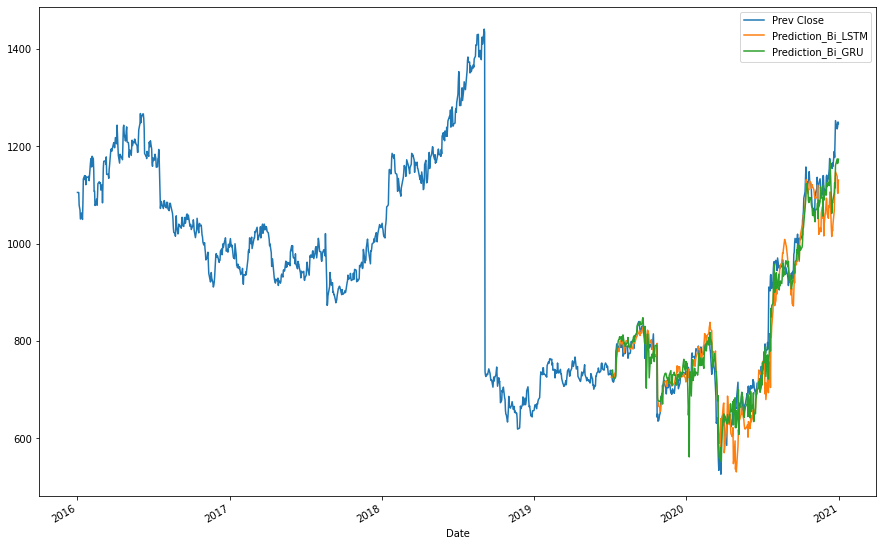

In [198]:
df[[ 'Prev Close','Prediction_Bi_LSTM','Prediction_Bi_GRU']].plot(figsize=(15,10));

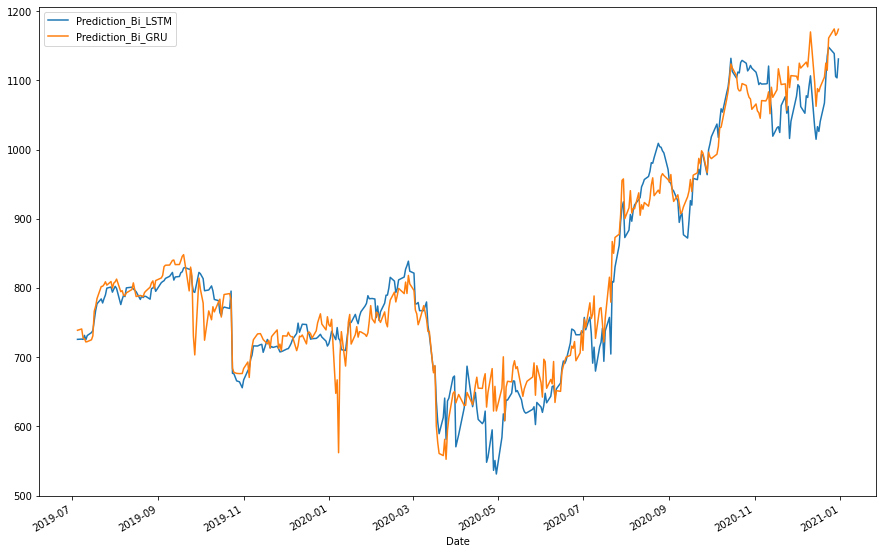

In [199]:
df[[ 'Prediction_Bi_LSTM','Prediction_Bi_GRU']].plot(figsize=(15,10));

Evaluation

In [200]:
pred_bi_lstm=df['Prediction_Bi_LSTM']
pred_bi_lstm.dropna(inplace=True)

In [201]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_bi_lstm))
print(rmse)

51.0313549408321


In [202]:
error=mean_absolute_error(test['Prev Close'],pred_bi_lstm)
print(error)

35.6370186401265


In [203]:
r2_score(test['Prev Close'],pred_bi_lstm)

0.9051275256563913

In [204]:
pred_bi_gru=df['Prediction_Bi_GRU']
pred_bi_gru.dropna(inplace=True)

In [205]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_bi_gru))
print(rmse)

37.99290873072304


In [206]:
error=mean_absolute_error(test['Prev Close'],pred_bi_gru)
print(error)

28.126039695563016


In [207]:
r2_score(test['Prev Close'],pred_bi_gru)

0.9474138813323139